            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

# Data Preprocessing

In [11]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [14]:
# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


In [15]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-11 09:53:10,93143,3350,view,0,1,18,Russia,Saint Petersburg,0,Android,ads,"Clinical trials of monoclonal antibodies, whic...",covid
1,2021-11-11 09:55:19,93143,6695,view,0,1,18,Russia,Saint Petersburg,0,Android,ads,Nagra comes from conservative Indian family th...,movie
2,2021-11-11 09:56:05,93143,4944,view,0,1,18,Russia,Saint Petersburg,0,Android,ads,Ive spent quite a while going through all the ...,movie
3,2021-11-11 09:56:18,93143,2171,view,0,1,18,Russia,Saint Petersburg,0,Android,ads,Warnings on woeful wi-fi security\n\nCompanies...,tech
4,2021-11-11 09:57:13,93143,5555,view,0,1,18,Russia,Saint Petersburg,0,Android,ads,I had the great pleasure of recently viewing t...,movie


# Ferauture engineering

### Time
Here we will create 3 new feautures from the timestamp:
1. hour_of_day
2. time_since_last_action
3. day_of_week

In [16]:
import pandas as pd

# Convert the timestamp format to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract features from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Calculate the time since the last action for each user
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)


In [17]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
685,2021-12-29 08:51:48,7812,806,view,0,1,24,Russia,Smolensk,2,Android,ads,OutKast win at MTV Europe Awards\n\nUS hip-hop...,entertainment,2,8,0.0
686,2021-12-29 08:53:42,7812,162,view,0,1,24,Russia,Smolensk,2,Android,ads,Alfa Romeos to get GM engines\n\nFiat is to st...,business,2,8,114.0
687,2021-12-29 08:54:12,7812,1847,view,1,1,24,Russia,Smolensk,2,Android,ads,Holmes starts 2005 with GB events\n\nKelly Hol...,sport,2,8,30.0
688,2021-12-29 08:54:32,7812,1847,like,0,1,24,Russia,Smolensk,2,Android,ads,Holmes starts 2005 with GB events\n\nKelly Hol...,sport,2,8,20.0
689,2021-12-29 08:54:34,7812,2165,view,0,1,24,Russia,Smolensk,2,Android,ads,Slimmer PlayStation triple sales\n\nSony PlayS...,tech,2,8,2.0


### One hot encoding

In [18]:
# One-hot encoding for 'country', 'city', and 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

In [19]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Yekaterinburg,city_Yelabuga,city_Zayukovo,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
685,2021-12-29 08:51:48,7812,806,view,0,1,24,2,Android,ads,...,0,0,0,0,0,1,0,0,0,0
686,2021-12-29 08:53:42,7812,162,view,0,1,24,2,Android,ads,...,0,0,0,1,0,0,0,0,0,0
687,2021-12-29 08:54:12,7812,1847,view,1,1,24,2,Android,ads,...,0,0,0,0,0,0,0,0,1,0
688,2021-12-29 08:54:32,7812,1847,like,0,1,24,2,Android,ads,...,0,0,0,0,0,0,0,0,1,0
689,2021-12-29 08:54:34,7812,2165,view,0,1,24,2,Android,ads,...,0,0,0,0,0,0,0,0,0,1


### Label encoding

In [23]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding for 'gender', 'os', and 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])


In [24]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Yekaterinburg,city_Yelabuga,city_Zayukovo,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
685,2021-12-29 08:51:48,7812,806,1,0,1,24,2,0,0,...,0,0,0,0,0,1,0,0,0,0
686,2021-12-29 08:53:42,7812,162,1,0,1,24,2,0,0,...,0,0,0,1,0,0,0,0,0,0
687,2021-12-29 08:54:12,7812,1847,1,1,1,24,2,0,0,...,0,0,0,0,0,0,0,0,1,0
688,2021-12-29 08:54:32,7812,1847,0,0,1,24,2,0,0,...,0,0,0,0,0,0,0,0,1,0
689,2021-12-29 08:54:34,7812,2165,1,0,1,24,2,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
# check data type of each column
print(data.dtypes)

timestamp              datetime64[ns]
user_id                         int64
post_id                         int64
action                          int64
target                          int64
                            ...      
topic_entertainment             uint8
topic_movie                     uint8
topic_politics                  uint8
topic_sport                     uint8
topic_tech                      uint8
Length: 174, dtype: object


идеи для создания новых признаков:

1. Количество просмотров и лайков для каждого пользователя.
2. Количество просмотров и лайков для каждого поста.
3. Среднее время между просмотрами для каждого пользователя.
4. Доля лайков от просмотров для каждого пользователя и поста.
5. Количество просмотров и лайков для каждой темы.
6. Количество просмотров и лайков для каждой операционной системы и источника трафика.
7. Доля просмотров и лайков для каждой темы от общего числа просмотров и лайков пользователя.

### Количество просмотров и лайков для каждого пользователя, os, source, topic

In [26]:
# Feature 1: Количество просмотров и лайков для каждого пользователя
user_views_likes = data.groupby('user_id')['action'].value_counts().unstack().fillna(0)
user_views_likes.columns = ['user_views', 'user_likes']
data = data.merge(user_views_likes, on='user_id', how='left')

# Feature 2: Количество просмотров и лайков для каждого поста
post_views_likes = data.groupby('post_id')['action'].value_counts().unstack().fillna(0)
post_views_likes.columns = ['post_views', 'post_likes']
data = data.merge(post_views_likes, on='post_id', how='left')


In [29]:
temp_df = data[['exp_group', 'topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'action']]
for col in ['topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech']:
    temp_df[col] = temp_df[col] * temp_df['action']
grouped_data = temp_df.groupby('exp_group').sum().reset_index()
grouped_data.columns = ['exp_group'] + [f'{col}_exp_group_views' if i % 2 == 0 else f'{col}_exp_group_likes' for i, col in enumerate(grouped_data.columns[1:], 1)]
data = data.merge(grouped_data, on='exp_group', how='left')


C:\Users\Alex\AppData\Local\Temp\ipykernel_38284\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']


In [30]:
# print the list of columns
print(data.columns.tolist())

['timestamp', 'user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Azerbaijan', 'country_Belarus', 'country_Estonia', 'country_Finland', 'country_Kazakhstan', 'country_Latvia', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Achikulak', 'city_Achinsk', 'city_Aniskino', 'city_Arkhangelsk', 'city_Arzamas', 'city_Babruysk', 'city_Baku', 'city_Balashikha', 'city_Balashov', 'city_Barnaul', 'city_Belgorod', 'city_Berdsk', 'city_Berezniki', 'city_Bila Tserkva', 'city_Birobidzhan', 'city_Bogotol', 'city_Boguchar', 'city_Bryansk', 'city_Cheboksary', 'city_Chekhov', 'city_Chelyabinsk', 'city_Chistopol', 'city_Davyd-Haradok', 'city_Divnogorsk', 'city_Dzyatlava', 'city_Elektrogorsk', 'city_Fëdorovka', 'city_Georgiyevsk', 'city_Gvardeysk', 'city_Helsinki', 'city_Homyel’', 'city_Irkutsk', 'city_Ivanovo', 'city_Izhevsk', 'city_Jyväskylä', 'city_Kaluga', 'city_Kapaklı', 'city_Kaspiy

## Feauture selection

### Pearson's Correlation Coefficient

In [33]:
import pandas as pd
import numpy as np

# Assuming your data is in a DataFrame called 'data'
# and your target variable is in a column called 'target'

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations between each feature and the target variable
target_correlations = correlation_matrix['target'].drop('target')

# Sort the correlations by their absolute values in descending order
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

# Select the top k features with the highest absolute correlations
k = 50  # You can choose any number based on your requirements
top_k_features = sorted_correlations.head(k).index.tolist()

# Create a new DataFrame with the selected features
selected_data = data[top_k_features]

print("Top", k, "features:")
print(top_k_features)
print("\nSelected data:")
print(selected_data.head())


C:\Users\Alex\AppData\Local\Temp\ipykernel_38284\3439295280.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Top 50 features:
['post_views', 'action', 'user_views', 'country_Russia', 'topic_politics_exp_group_likes', 'topic_sport_exp_group_views', 'country_Ukraine', 'country_Belarus', 'action_exp_group_views', 'city_Davyd-Haradok', 'topic_movie_exp_group_views', 'topic_covid_exp_group_views', 'topic_tech_exp_group_likes', 'city_Mariupol', 'post_likes', 'gender', 'topic_business_exp_group_likes', 'time_since_last_action', 'city_Bila Tserkva', 'city_Novosibirsk', 'city_Moscow', 'city_Novokuznetsk', 'city_Uglich', 'city_Korolëv', 'city_Kropotkin', 'city_Berdsk', 'city_Babruysk', 'topic_entertainment_exp_group_likes', 'city_Kirov', 'city_Chistopol', 'city_Kemerovo', 'country_Azerbaijan', 'city_Baku', 'city_Kyiv', 'city_Ryazan', 'city_Achinsk', 'city_Krupki', 'city_Kursk', 'city_Velyka Andrusivka', 'city_Saint Petersburg', 'city_Berezniki', 'country_Finland', 'city_Perm', 'city_Volnoye', 'city_Ussuriysk', 'city_Mykolaiv', 'city_Podolsk', 'city_Shakhty', 'city_Nogliki', 'city_Nadym']

Selected data

C:\Users\Alex\AppData\Local\Temp\ipykernel_38284\1391933483.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


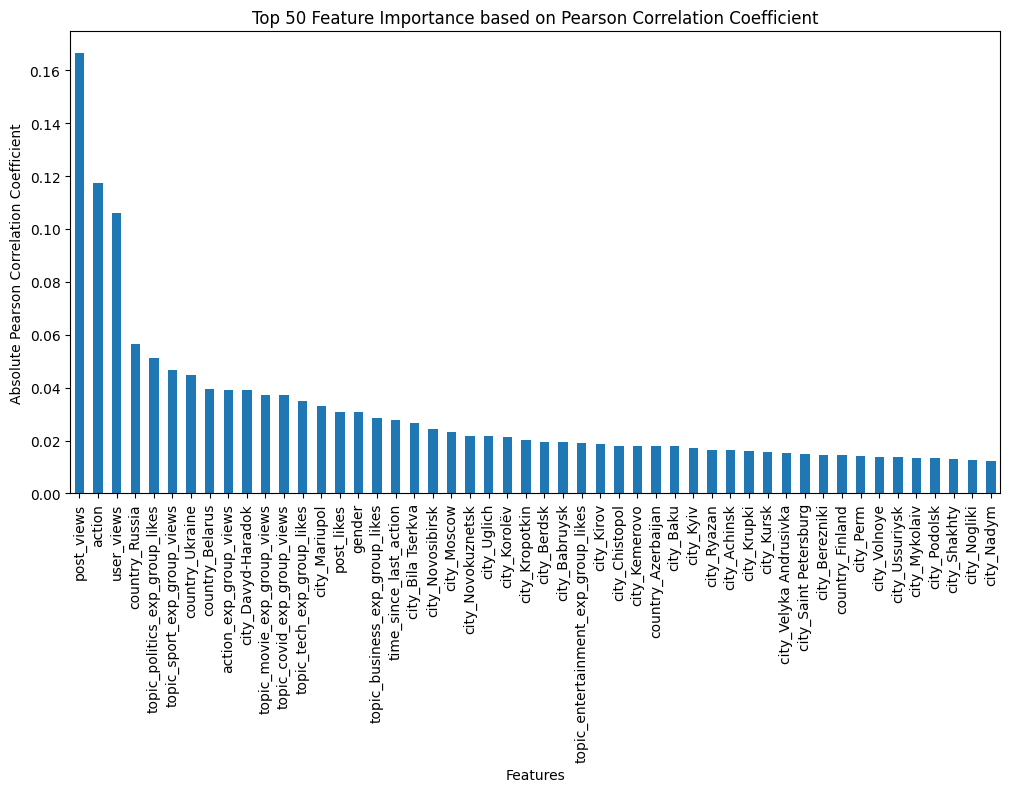

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_top_features(num_top_features):
    # Assuming your data is in a DataFrame called 'data'
    # and your target variable is in a column called 'target'

    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Get the correlations between each feature and the target variable
    target_correlations = correlation_matrix['target'].drop('target')

    # Sort the correlations by their absolute values in descending order
    sorted_correlations = target_correlations.abs().sort_values(ascending=False)

    # Select the top features
    top_features = sorted_correlations.head(num_top_features)

    # Plot the feature importances
    plt.figure(figsize=(12, 6))
    top_features.plot(kind='bar')
    plt.xlabel('Features')
    plt.ylabel('Absolute Pearson Correlation Coefficient')
    plt.title(f'Top {num_top_features} Feature Importance based on Pearson Correlation Coefficient')
    plt.show()

# Call the function with the desired number of top features to display
plot_top_features(50)


### Mutual Information

In [41]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Assume `data` is your DataFrame with features and target
X = data.drop(['target', 'timestamp', 'text'], axis=1)
y = data['target']

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their corresponding MI scores
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Sort the DataFrame by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# Optionally, select the top k features using SelectKBest
k = 30
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)


Top k features based on mutual information:
Index(['user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'hour_of_day', 'time_since_last_action', 'country_Russia',
       'city_Bila Tserkva', 'city_Elektrogorsk', 'city_Helsinki',
       'city_Korolëv', 'city_Minsk', 'city_Vichuga', 'city_Zayukovo',
       'topic_covid', 'topic_movie', 'user_views', 'user_likes', 'post_views',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'],
      dtype='object')
